# Using SNM to test GP formalism

## Alexandra Semposki

### Date: 09 September 2024

We attempt to understand the addition of more data to the symmetric nuclear matter result, to see if this reduces the uncertainties predicted in the GP, or if this has no effect.

In [1]:
%load_ext autoreload
%autoreload 2

# import packages
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from matplotlib.axes import Axes

sys.path.append('../src')
sys.path.append('../data')

from gp_utils import GaussianProcessRegressor2dNoise
from eos_utils import *
from scripts import *

setup_rc_params()

# define saturation up here
n0 = 0.164

# color plotting assistance
orders = [0, 1, 2, 3]
order_labels = [r'$\chi$EFT (N$^{3}$LO)', r'pQCD (N$^{2}$LO)', 'Mixed Model']
color_list = ['Reds', 'Blues','Purples', 'Oranges', 'Greens', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(orders)]]
colors = [cmap(0.7 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color, 0.5) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]

In [2]:
# import the saved data from SNM calculations
data_xeft = np.load('../data/eos_data/pressure_chiral_data_scaled_2n0.npz')
print(data_xeft['density'].shape)
data_pqcd = np.load('../data/eos_data/pressure_pqcd_data_scaled.npz')  # unnecessary but need more general code

# get the training points we'd like to begin with
cutoff = 40
training_chiral, training_pqcd, training_data_full = gp_data(data_xeft, data_pqcd, cutoff)

# cut the pQCD data out for now
training_data_2 = {
    'dens': training_chiral['dens'],
    'mean': training_chiral['mean'],
    'std': training_chiral['std'],
    'cov': training_chiral['cov']
}
# label pQCD data for later
# training_pqcd = {
#     'dens': training_data_full['dens'][7:],
#     'mean': training_data_full['mean'][7:],
#     'std': training_data_full['std'][7:],
#     'cov': training_data_full['cov'][7:,7:],
# }

# assign testing array (no equal points in training)
density_test = np.linspace(0.05, 16.4, 900)[:-1]

# cut this in half to obtain starting data
training_data = {
    'dens': training_data_2['dens'][::2],
    'mean': training_data_2['mean'][::2],
    'std': training_data_2['std'][::2],
    'cov': training_data_2['cov'][::2,::2]
}

# print results to check
print('Density: \n', training_data_2['dens'])
print('\nMean: \n', training_data_2['mean'])
print('\nStd dev: \n', training_data_2['std'])

print('\nDensity: \n', training_data['dens'])
print('\nMean: \n', training_data['mean'])
print('\nStd dev: \n', training_data['std'])

(300,)
(8,) (8,) (8,) (8, 8)
(8,) (8,) (8,) (8, 8)
(4,) (4,) (4,) (4, 4)
Cov shape: (12, 12)
Density: 
 [0.11110368 0.14214047 0.17317726 0.20421405 0.23525084 0.26628763
 0.29732441 0.3283612 ]

Mean: 
 [-0.03239468 -0.0183213   0.00466064  0.03497449  0.07090435  0.1105411
  0.15180187  0.19254359]

Std dev: 
 [0.00505232 0.00851956 0.0130119  0.0185972  0.02534387 0.03332475
 0.04261458 0.05329999]

Density: 
 [0.11110368 0.17317726 0.23525084 0.29732441]

Mean: 
 [-0.03239468  0.00466064  0.07090435  0.15180187]

Std dev: 
 [0.00505232 0.0130119  0.02534387 0.04261458]


__NOTE__: We need to test not using points under saturation density in this toy example, again.

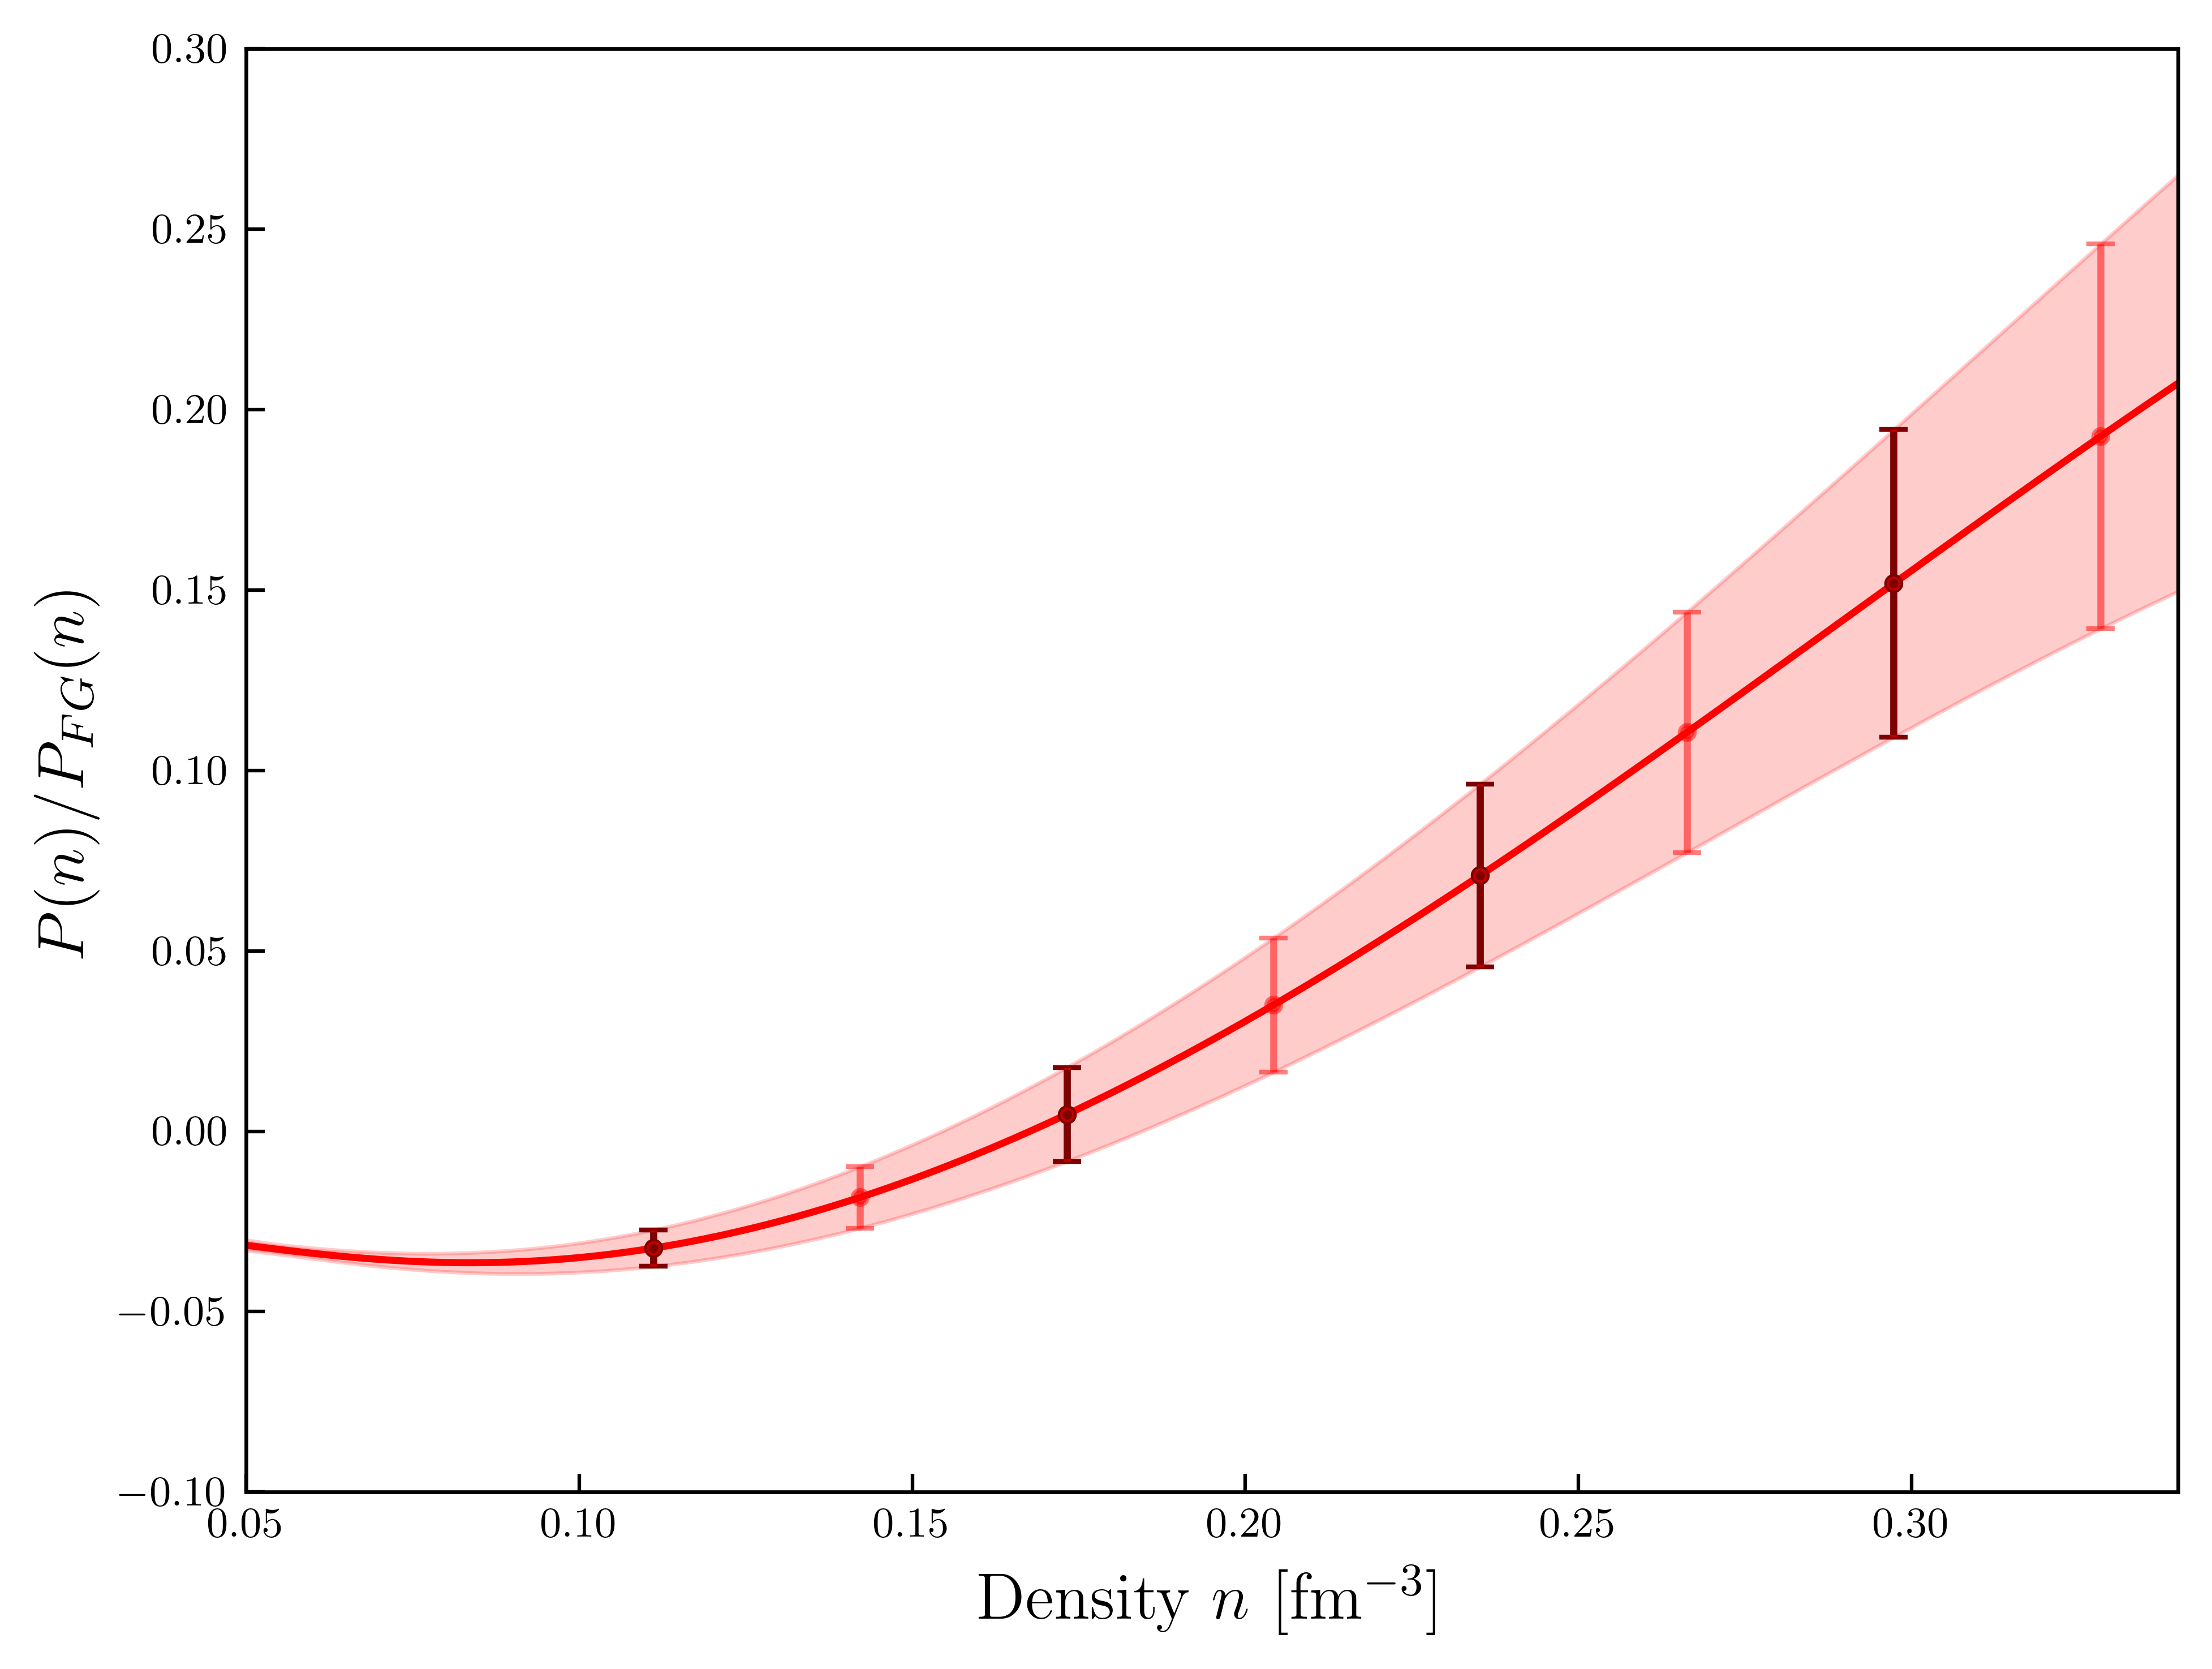

In [3]:
errorbar_kwargs = dict(
    capsize=3,
    ecolor="k",
    ls="none",
    marker="o",
    markerfacecolor="k",
    markeredgecolor="k",
    markersize=3
)

errorbar_kwargs_2 = dict(
    capsize=3,
    ecolor="r",
    ls="none",
    marker="o",
    markerfacecolor="r",
    markeredgecolor="r",
    markersize=3,
    alpha=0.5
)

# chiral EFT data 
n_xeft = data_xeft['density']
p_mean_xeft = data_xeft['mean'][:, -1]
p_stdv_xeft = data_xeft['std_dev'][:, -1]
p_cov_xeft = data_xeft['cov'][..., -1]

# plot the current data sets
fig, ax = plt.subplots(dpi=600)
ax: Axes
color_xeft = "red"
color_pqcd = "blue"
ax.set_xlim(1.0, 100.0)
ax.set_ylim(0, 1.2)
ax.set_xlim(0.05, 0.34)
ax.set_ylim(-0.1, 0.3)
#ax.set_xscale('log')
ax.set_ylabel(r'$P(n)/P_{FG}(n)$', fontsize=14)
ax.set_xlabel(r'Density $n$ [fm$^{-3}$]', fontsize=14)
ax.plot(n_xeft, p_mean_xeft, color='red', label=r'ChEFT (N3LO)')
ax.fill_between(n_xeft, p_mean_xeft-p_stdv_xeft, \
                p_mean_xeft+p_stdv_xeft, alpha=0.2, color=color_xeft)
ax.errorbar(x=training_data['dens'], y=training_data['mean'], yerr=training_data['std'], **errorbar_kwargs)
ax.errorbar(x=training_data_2['dens'], y=training_data_2['mean'], yerr=training_data_2['std'], \
            **errorbar_kwargs_2)
plt.show()

In [4]:
# print(training_data['cov'])
# print('\n')
# print(training_data_2['cov'])

print('Eigenvalues of the small covariance matrix: \n{}'.format(np.linalg.eig(training_data['cov'])[0]))

Eigenvalues of the small covariance matrix: 
[2.53516014e-03 1.12301534e-04 5.44603526e-06 2.42094295e-07]


Now, we can try to fit a GP to this again. Noting that the error bands came from a GP to begin with.

In [5]:
# set up the kernel
if cutoff == 20:
    kernel = C(constant_value=1.1, constant_value_bounds=[0.3,2.25]) * \
    RBF(length_scale=0.8, length_scale_bounds=[0.3,1.0])  # 40n0 => 0.9, [0.7,1.2] # 20n0 => 1.1?
elif cutoff == 40:
    kernel = C(constant_value=1.1, constant_value_bounds=[0.3,2.25]) * \
    RBF(length_scale=0.9, length_scale_bounds=[0.6,1.2])  # 40n0 => 0.9, [0.7,1.2] # 20n0 => 1.1?
#kernel = C(constant_value=0.6) * RBF(length_scale=1.16, length_scale_bounds='fixed')

X_train = np.log(training_data['dens']).reshape(-1,1)  # training in the log scale
X_train_2 = np.log(training_data_2['dens']).reshape(-1,1)
y_train = training_data['mean'].reshape(-1,1)
y_train_2 = training_data_2['mean'].reshape(-1,1)

In [6]:
# set up the class for the GP
# chicken nugget
nugget = 1e-08*np.eye(len(training_data['cov']))
nugget2 = 1e-08*np.eye(len(training_data_2['cov']))

gp = GaussianProcessRegressor2dNoise(
    kernel=kernel,
    alpha=training_data['cov'] + nugget,  # here is where we input the full covariance matrix from the data
    n_restarts_optimizer=10000)

gp1 = GaussianProcessRegressor2dNoise(
    kernel=kernel,
    alpha=training_data_2['cov'] + nugget2,  # here is where we input the full covariance matrix from the data
    n_restarts_optimizer=10000)

gp.fit(X_train, y_train, cutoff=cutoff, priors=True, prior_choice='truncnorm_15')  
gp1.fit(X_train_2, y_train_2, cutoff=cutoff, priors=True, prior_choice='truncnorm_15')  

print(gp.kernel_)
print(gp1.kernel_)

0.934**2 * RBF(length_scale=1.05)
0.915**2 * RBF(length_scale=1.12)


In [7]:
# predict using this GP
X = np.log(density_test).reshape(-1,1)
y_pred, y_stdv = gp.predict(X, return_std=True)
_ , y_cov = gp.predict(X, return_cov=True)

y_pred_2, y_stdv_2 = gp1.predict(X, return_std=True)
_ , y_cov_2 = gp1.predict(X, return_cov=True)

In [8]:
# compare the size of the error bars for both theories below at some select point (last point)
band_chiral = p_stdv_xeft[-1]
band_gp = y_stdv[16]           # 2n0
band_gp1 = y_stdv_2[16]

print('Density at chosen point:', density_test[16], 'fm^-3')

# differences to highlight on the plot for compact saving
diff_chiral_gp1 = round(((band_chiral - band_gp)/(band_chiral))*100, 2)
diff_chiral_gp2 = round(((band_chiral - band_gp1)/(band_chiral))*100, 2)
diff_gps = round(((band_gp - band_gp1)/(band_gp + band_gp1))*100, 2)

# print out the differences
print('Difference between chiral and GP with 4 points: ', diff_chiral_gp1)
print('Difference between chiral and GP with 2x points: ', diff_chiral_gp2)
print('Difference between the two GPs: ', diff_gps)

Density at chosen point: 0.3409899888765294 fm^-3
Difference between chiral and GP with 4 points:  2.72
Difference between chiral and GP with 2x points:  4.13
Difference between the two GPs:  0.73


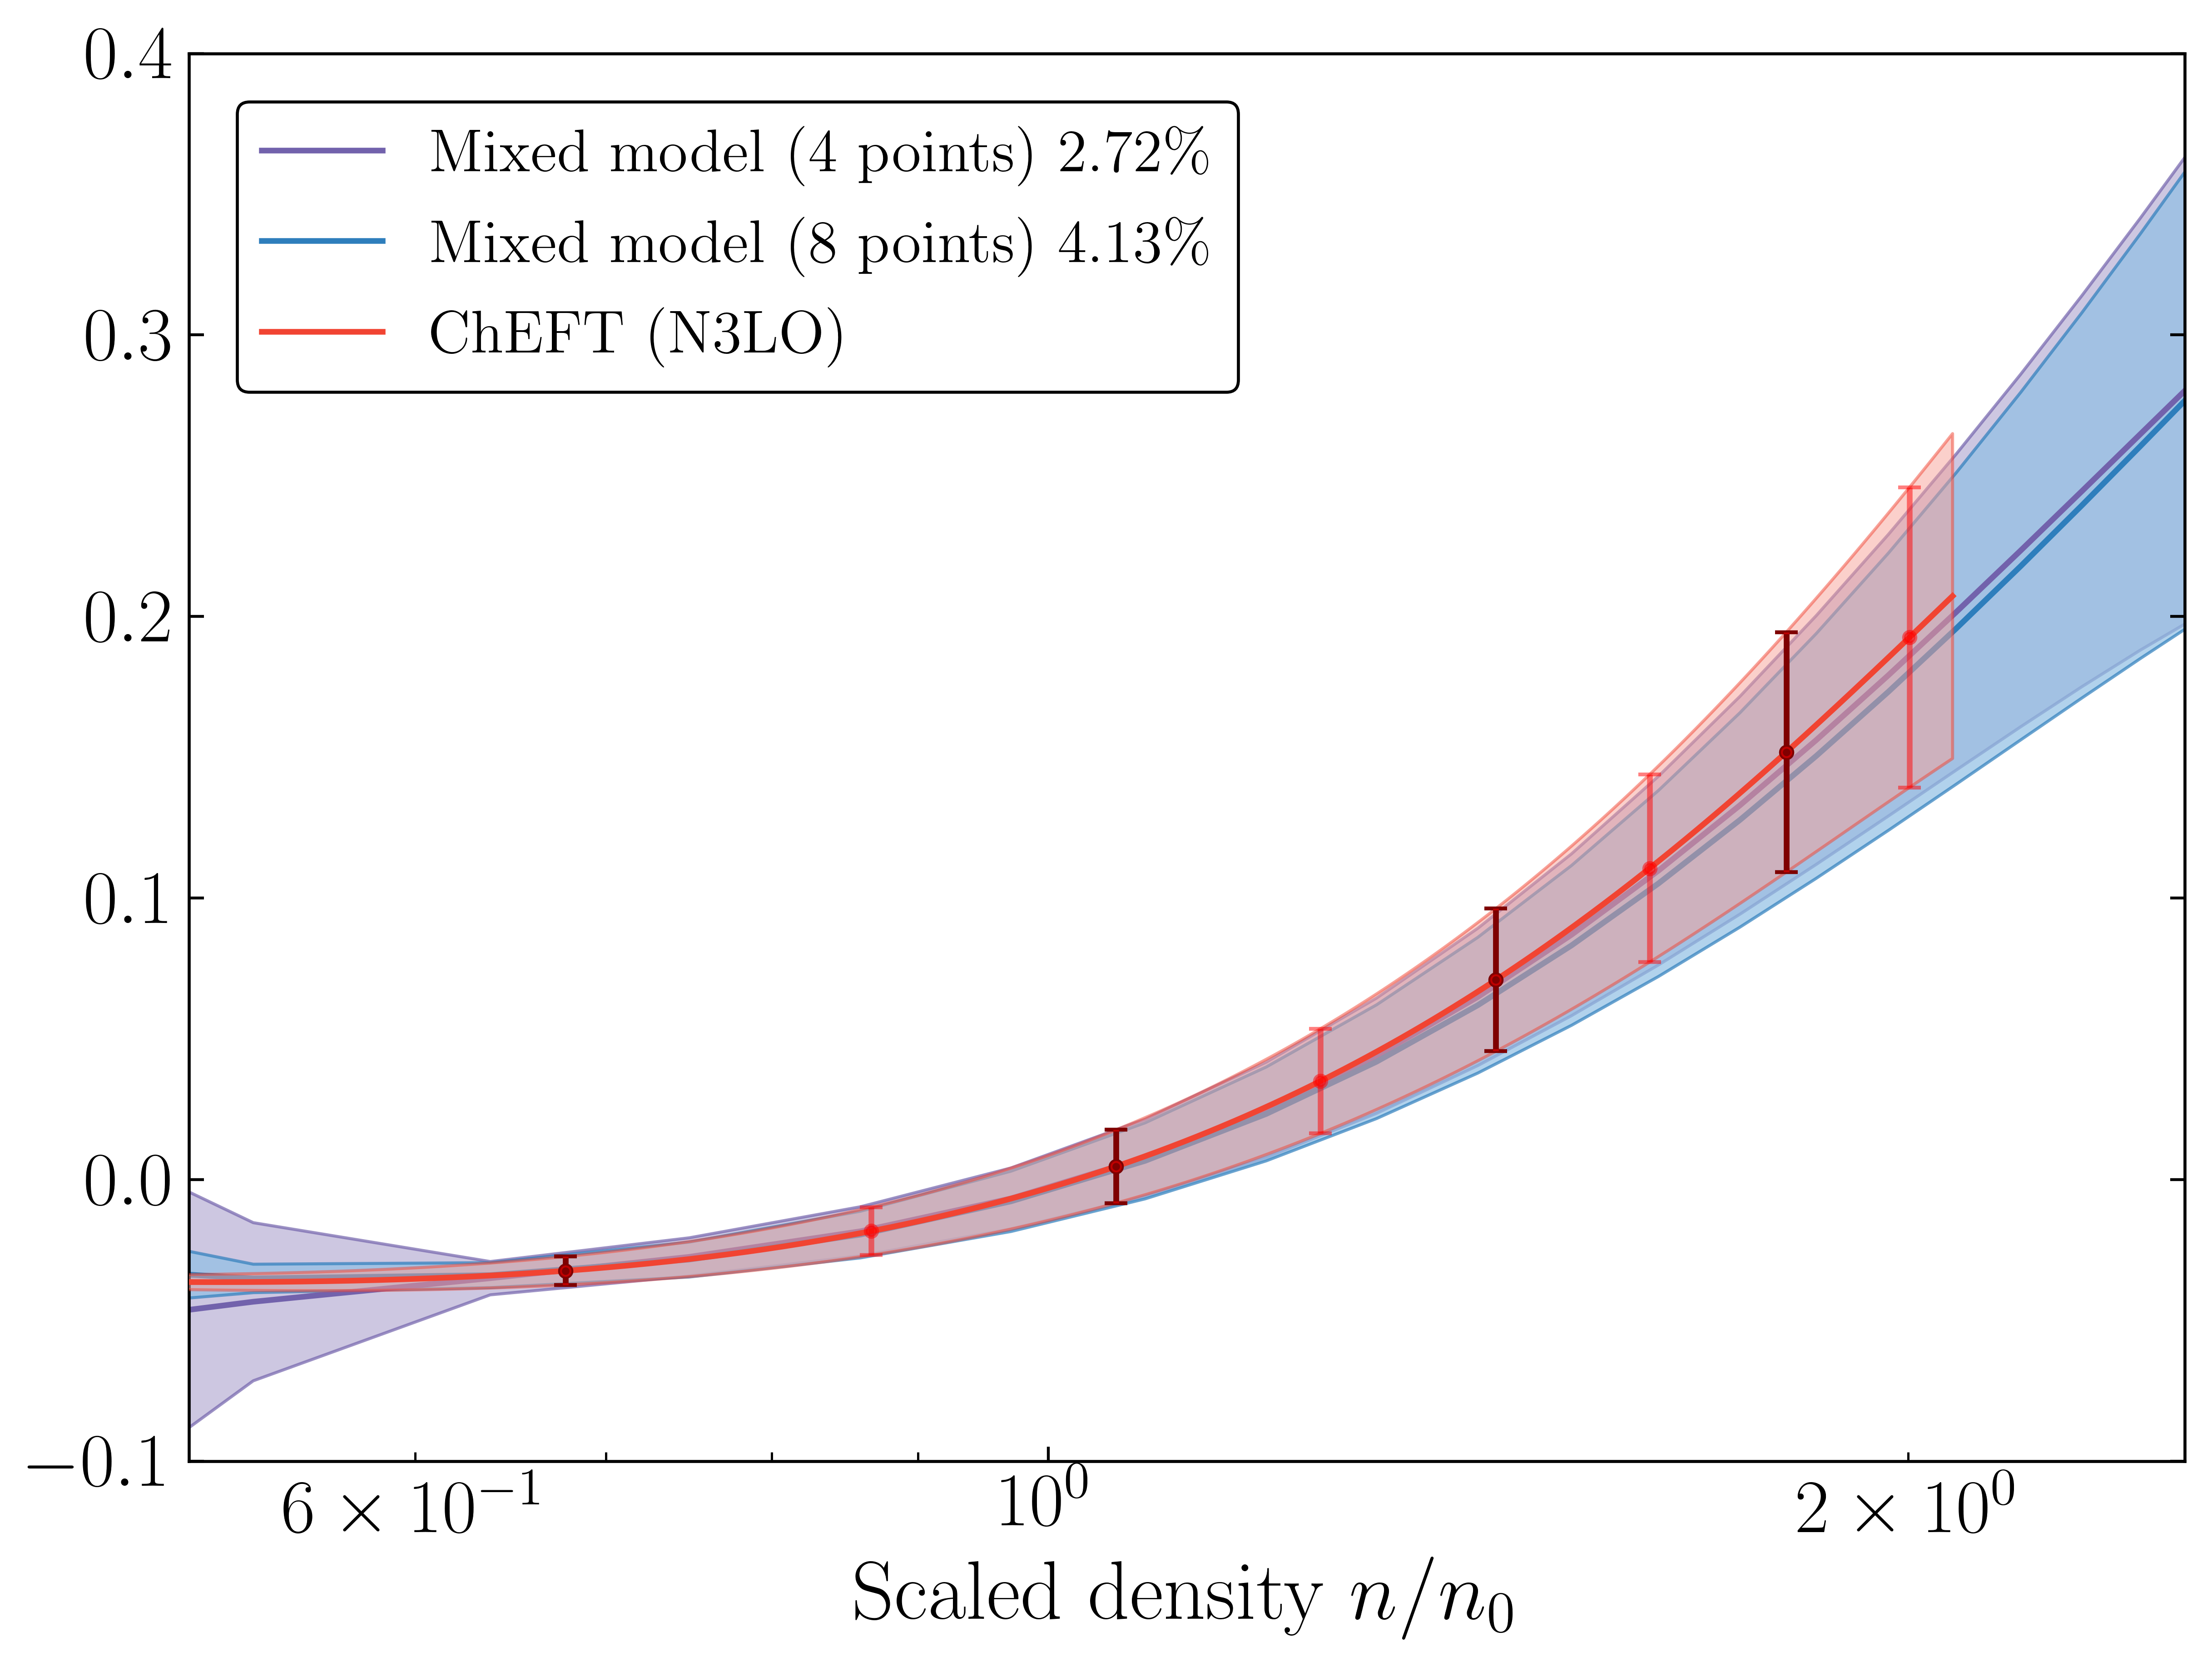

In [9]:
fig, ax = plt.subplots(figsize=(8,6), dpi=600)
ax.set_xlim(0.5, 2.5)
#ax.set_ylim(-0.1, 1.4)
ax.tick_params(axis='both', which='major', labelsize=20, right=True)
ax.tick_params(axis='both', which='minor', labelsize=20, right=True)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.set_xscale('log') # plot in log base 10
ax.set_xlabel(r'Scaled density $n/n_{0}$', fontsize=22)

# GP results and uncertainty bands
ax.plot(density_test/n0, y_pred, c=colors[2], \
        label=r'Mixed model ({} points) {}\%'.format(len(training_data['cov']), diff_chiral_gp1), zorder=-1)
ax.fill_between(density_test/n0, y_pred-y_stdv, y_pred+y_stdv, facecolor=light_colors[2], \
                edgecolor=colors[2], alpha=0.7, zorder=-2)

ax.plot(density_test/n0, y_pred_2, c=colors[1], \
        label=r'Mixed model ({} points) {}\%'.format(len(training_data_2['cov']), diff_chiral_gp2), zorder=-1)
ax.fill_between(density_test/n0, y_pred_2-y_stdv_2, y_pred_2+y_stdv_2, facecolor=light_colors[1], \
                edgecolor=colors[1], alpha=0.7, zorder=-2)

# chiral EFT and pQCD curves, training data
ax.plot(n_xeft/n0, p_mean_xeft, color=colors[0], label=r'ChEFT (N3LO)', zorder=5)
ax.fill_between(n_xeft/n0, p_mean_xeft-p_stdv_xeft, p_mean_xeft+p_stdv_xeft, alpha=0.5, \
                facecolor=light_colors[0], edgecolor=colors[0], zorder=4)
ax.errorbar(x=training_data['dens']/n0, y=training_data['mean'], yerr=training_data['std'], \
            **errorbar_kwargs, zorder=10)
ax.errorbar(x=training_data_2['dens']/n0, y=training_data_2['mean'], yerr=training_data_2['std'], \
            **errorbar_kwargs_2, zorder=10)

ax.set_ylim(-0.1, 0.4)
plt.legend(loc='upper left', fontsize=16)
plt.show()

In [10]:
# compare the size of the error bars for both theories below at some select point (last point)
band_chiral = p_stdv_xeft[-1]
band_gp = y_stdv[16]           # 2n0
band_gp1 = y_stdv_2[16]

print('Density at chosen point:', density_test[16], 'fm^-3')

# print out the differences
print('Difference between chiral and GP with 4 points: ', ((band_chiral - band_gp)/(band_chiral))*100)
print('Difference between chiral and GP with 2x points: ', ((band_chiral - band_gp1)/(band_chiral))*100)
print('Difference between the two GPs: ', ((band_gp - band_gp1)/(band_gp + band_gp1))*100)

Density at chosen point: 0.3409899888765294 fm^-3
Difference between chiral and GP with 4 points:  2.720743658614207
Difference between chiral and GP with 2x points:  4.134460355120102
Difference between the two GPs:  0.7319465633474396


I can get 2.56% ??? This means that pQCD is definitely still making a huge difference, because we could only ever achieve ~ 5% even with these priors when computing the full EOS with pQCD.

The error between adding more points doubles, but doesn't reduce greatly overall. Is this because the pQCD is doing more than expected too?

Error DOES get worse when not including points near to the edge of the chiral EFT band (compare 5% or so with 7 vs. 14 points, vs. this case of going to 13 points in the same range as the original 7, from 4.67% to 11.39%). So something is definitely up with that. Is this too many points in a lengthscale causing this? Let's add even more.

## SVD Analysis of SNM and the kernel structure

Here we'll look at the kernel SVD and the covariance matrix, and see how similar they are.

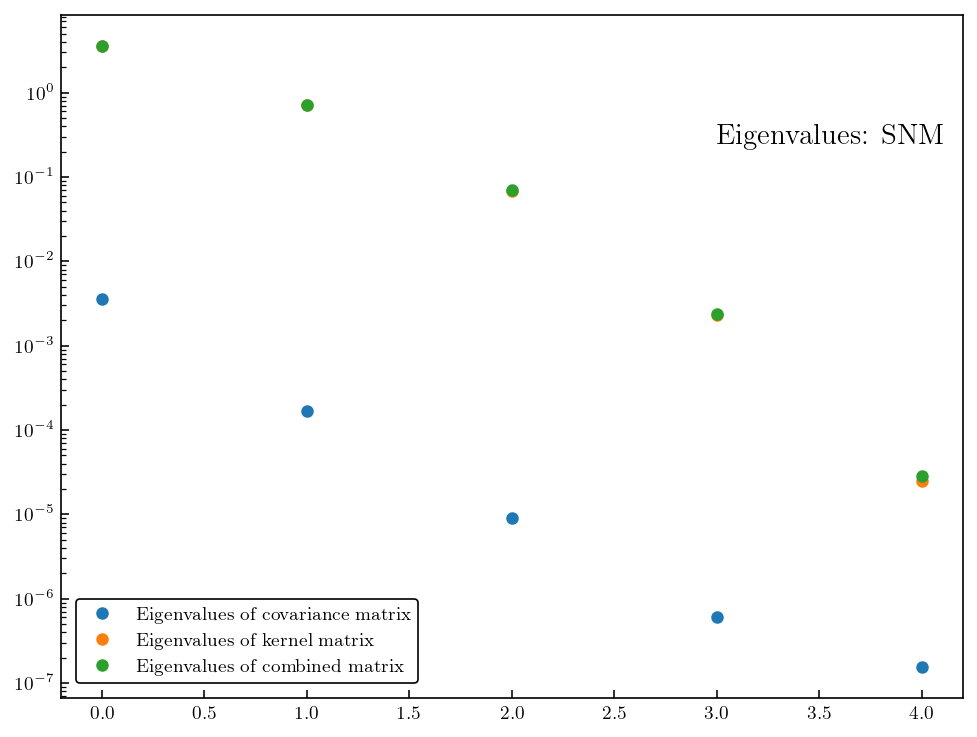

In [13]:
# get the SVD up and running
from scipy.linalg import svd
U_cov, S_cov, V_cov = svd(training_data['cov'])

# get SVD from the kernel matrix (get the kernel matrix...how?)
# set the kernel with optimized parameters from the training and then use that at the training points?
kernel = C(0.937**2.0, constant_value_bounds='fixed') \
* RBF(length_scale=1.08, length_scale_bounds='fixed')

# construct a new GP to tackle this?
gp_cov = GaussianProcessRegressor2dNoise(kernel, alpha=training_data['cov'])
gp_cov.fit(X_train, y_train)

# covariance matrix from kernel and SVD
cov_kernel = gp_cov.K_copy
U_kernel, S_kernel, V_kernel = svd(cov_kernel)

# combined matrix
cov_combined = cov_kernel + training_data['cov']
U_combined, S_combined, V_combined = svd(cov_combined)

# compare using svd
plt.plot(S_cov, '.', markersize=10, label=r'Eigenvalues of covariance matrix')
plt.plot(S_kernel, '.', markersize=10, label=r'Eigenvalues of kernel matrix')
plt.plot(S_combined, '.', markersize=10, label=r'Eigenvalues of combined matrix')
plt.yscale('log')
plt.text(3.0, 2.5e-1, r'Eigenvalues: SNM', fontsize=14)
plt.legend(loc='lower left')
plt.show()

## Adding pQCD back in

Now let's see if pQCD ruins everything and doesn't allow us to recapture the chiral correlation structure. Let's bring it back and train again, using the same ideas as here.

In [12]:
from scipy import linalg

# assign testing array (no equal points in training)
density_test = np.linspace(0.05, 16.4, 900)[:-1]

# cut this in half to obtain starting data
training_data_chiral = {
    'dens': training_data['dens'],
    'mean': training_data['mean'],
    'std': training_data['std'],
    'cov': training_data['cov']
}

# stitch pQCD back onto the matrices
training_data_2 = {
    'dens': np.concatenate((training_chiral['dens'][::2], training_pqcd['dens'])),
    'mean': np.concatenate((training_chiral['mean'][::2], training_pqcd['mean'])),
    'std': np.concatenate((training_chiral['std'][::2], training_pqcd['std'])),
    'cov': linalg.block_diag(training_chiral['cov'][::2,::2], training_pqcd['cov'])
}

training_data = {
    'dens': np.concatenate((training_data_chiral['dens'], training_pqcd['dens'])),
    'mean': np.concatenate((training_data_chiral['mean'], training_pqcd['mean'])),
    'std': np.concatenate((training_data_chiral['std'], training_pqcd['std'])),
    'cov': linalg.block_diag(training_data_chiral['cov'], training_pqcd['cov'])
}

# print results to check
print('Density: \n', training_data_2['dens'])
print('\nMean: \n', training_data_2['mean'])
print('\nStd dev: \n', training_data_2['std'])

print('\nDensity: \n', training_data['dens'])
print('\nMean: \n', training_data['mean'])
print('\nStd dev: \n', training_data['std'])

Density: 
 [ 0.11110368  0.17317726  0.23525084  0.29732441  6.5736227   9.30317195
 12.0327212  14.76227045]

Mean: 
 [-0.03239468  0.00466064  0.07090435  0.15180187  1.07796521  1.07160775
  1.06760099  1.0647593 ]

Std dev: 
 [0.00505232 0.0130119  0.02534387 0.04261458 0.01429028 0.01166593
 0.01015384 0.00914806]

Density: 
 [ 0.11110368  0.17317726  0.23525084  0.29732441  6.5736227   9.30317195
 12.0327212  14.76227045]

Mean: 
 [-0.03239468  0.00466064  0.07090435  0.15180187  1.07796521  1.07160775
  1.06760099  1.0647593 ]

Std dev: 
 [0.00505232 0.0130119  0.02534387 0.04261458 0.01429028 0.01166593
 0.01015384 0.00914806]


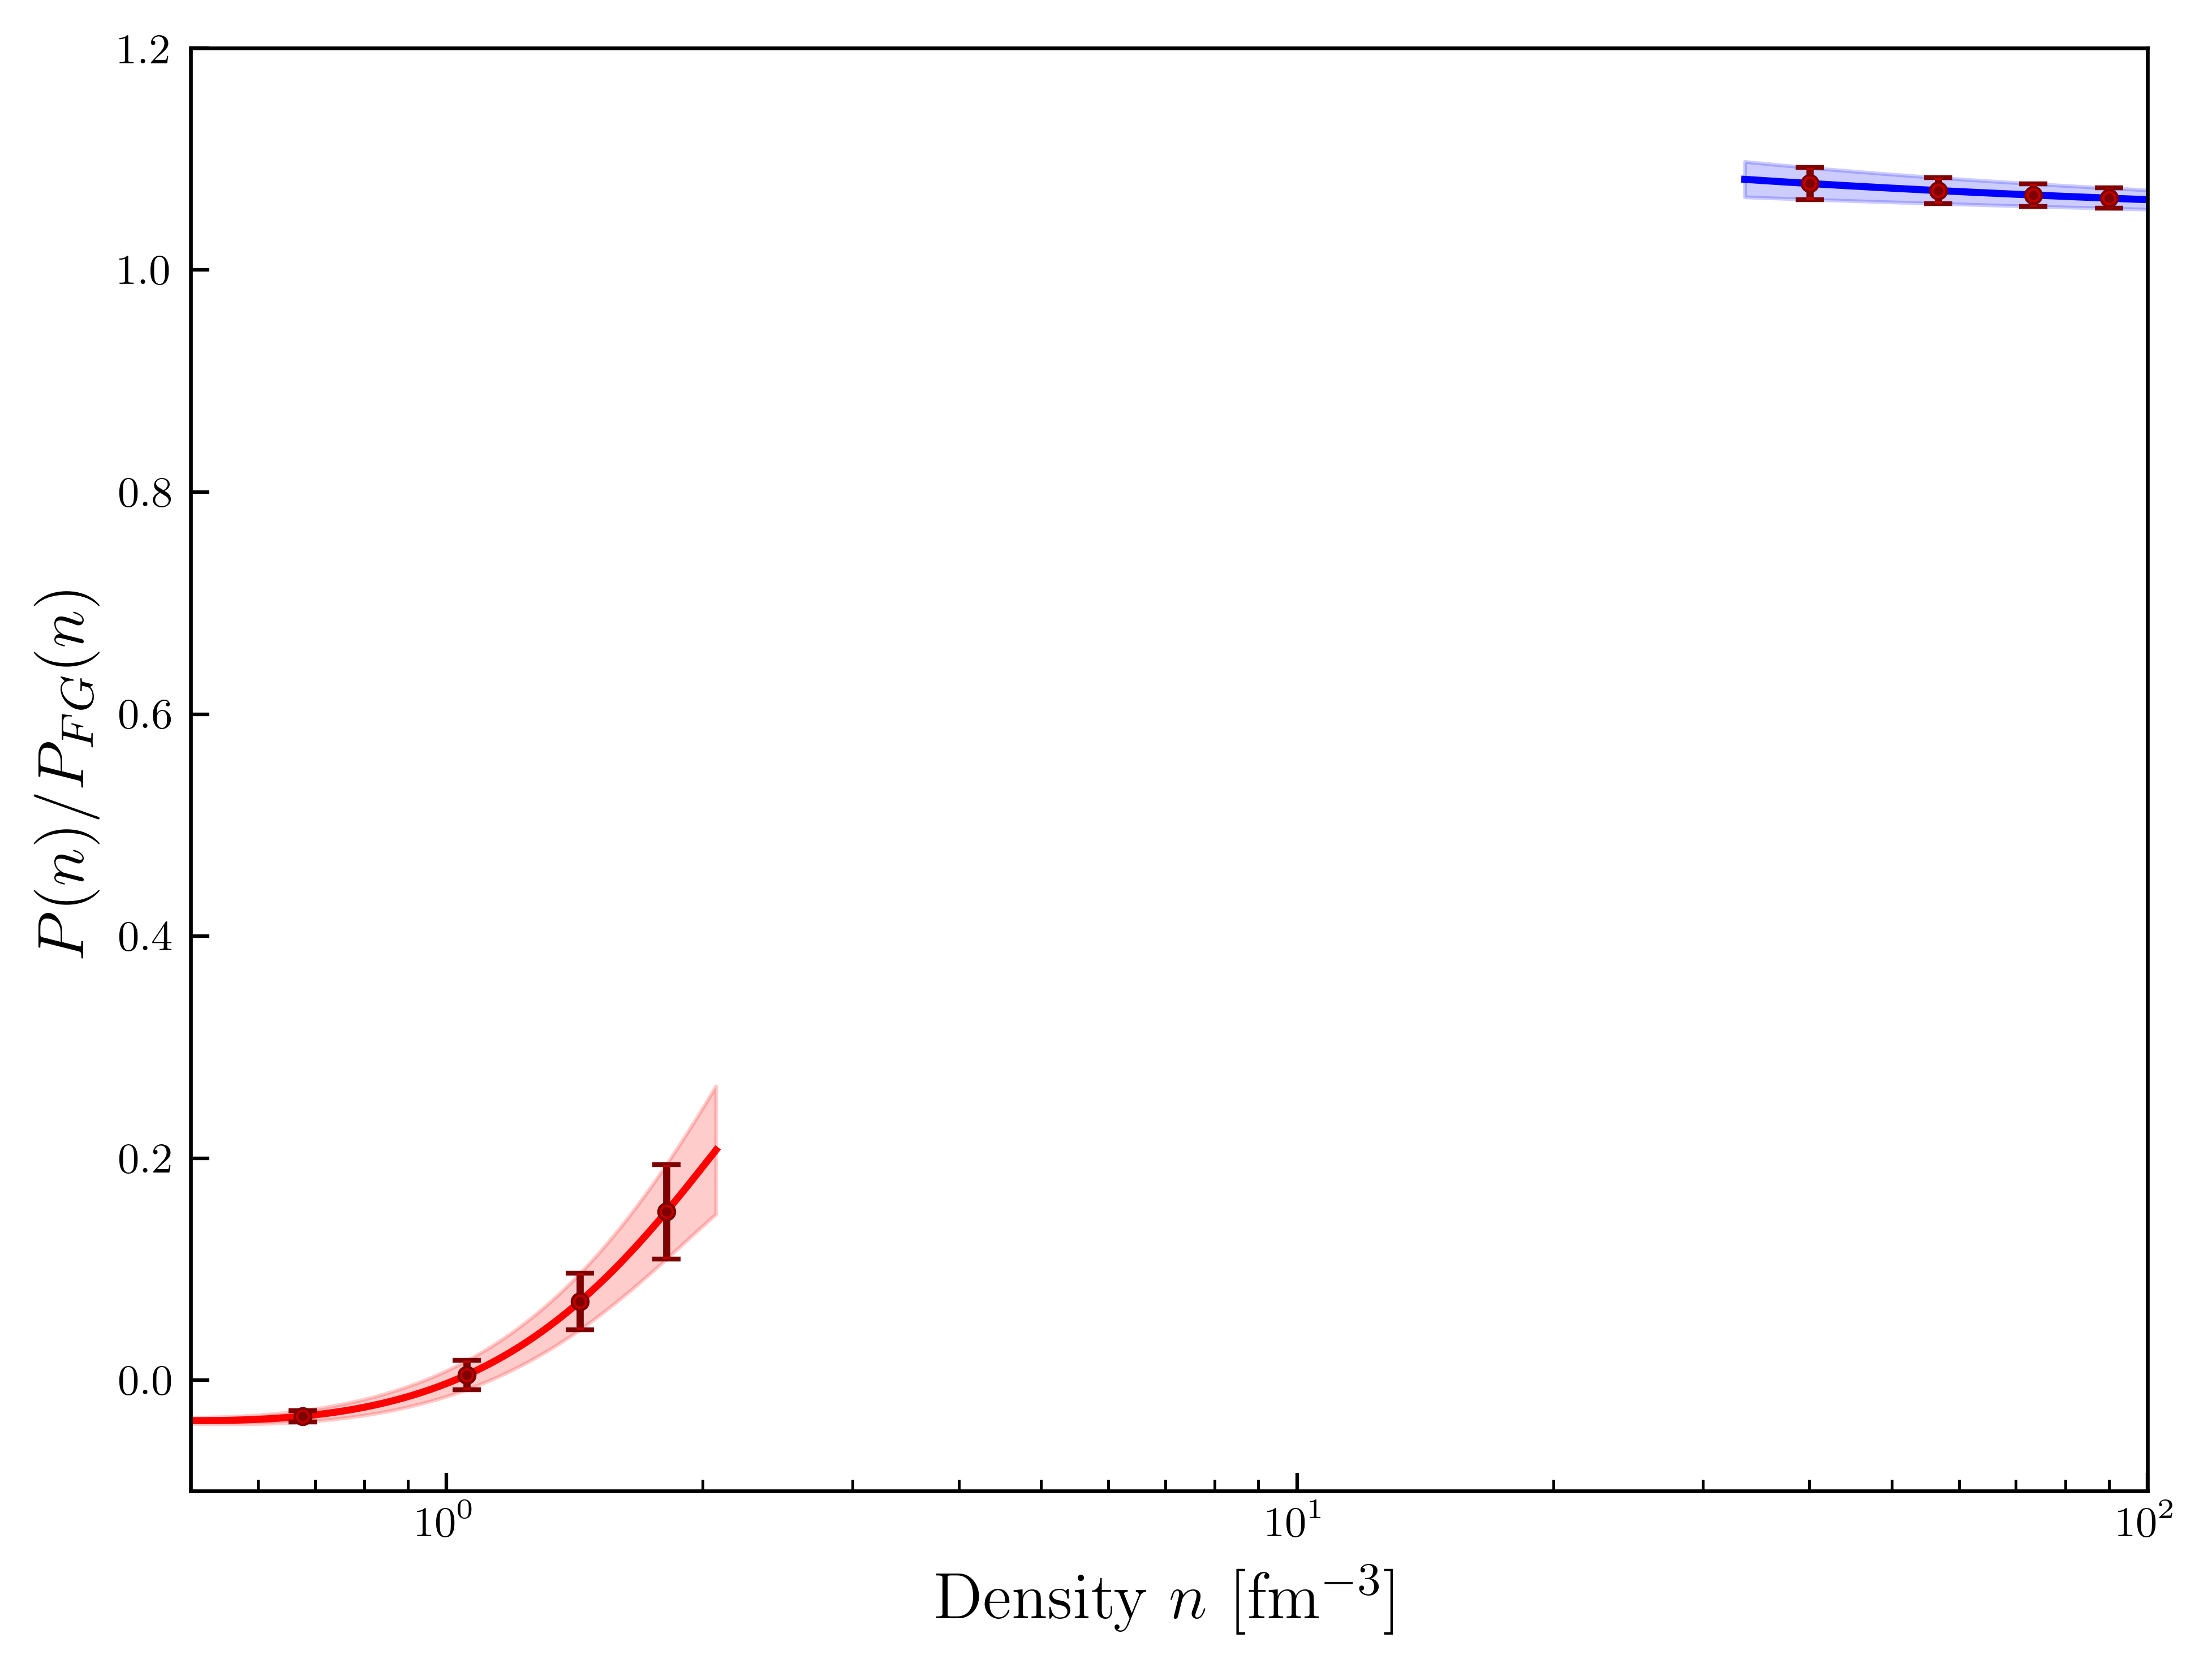

In [13]:
errorbar_kwargs = dict(
    capsize=3,
    ecolor="k",
    ls="none",
    marker="o",
    markerfacecolor="k",
    markeredgecolor="k",
    markersize=3
)

errorbar_kwargs_2 = dict(
    capsize=3,
    ecolor="r",
    ls="none",
    marker="o",
    markerfacecolor="r",
    markeredgecolor="r",
    markersize=3,
    alpha=0.5
)

# chiral EFT data 
n_xeft = data_xeft['density']
p_mean_xeft = data_xeft['mean'][:, -1]
p_stdv_xeft = data_xeft['std_dev'][:, -1]
p_cov_xeft = data_xeft['cov'][..., -1]

# plot the current data sets
fig, ax = plt.subplots(dpi=600)
ax: Axes
color_xeft = "red"
color_pqcd = "blue"
ax.set_xlim(0.5, 100.0)
ax.set_ylim(-0.1, 1.2)
ax.set_xscale('log')
ax.set_ylabel(r'$P(n)/P_{FG}(n)$', fontsize=14)
ax.set_xlabel(r'Density $n$ [fm$^{-3}$]', fontsize=14)
ax.plot(n_xeft/n0, p_mean_xeft, color='red', label=r'ChEFT (N3LO)')
ax.fill_between(n_xeft/n0, p_mean_xeft-p_stdv_xeft, \
                p_mean_xeft+p_stdv_xeft, alpha=0.2, color=color_xeft)
ax.plot(data_pqcd['density'][200:]/n0, data_pqcd['mean'][200:,-1], color=color_pqcd, label=r'pQCD (N2LO)')
ax.fill_between(data_pqcd['density'][200:]/n0, data_pqcd['mean'][200:,-1]-data_pqcd['std_dev'][200:,-1], \
                data_pqcd['mean'][200:,-1]+data_pqcd['std_dev'][200:,-1], color=color_pqcd, alpha=0.2)
ax.errorbar(x=training_data['dens']/n0, y=training_data['mean'], yerr=training_data['std'], **errorbar_kwargs)
ax.errorbar(x=training_data_2['dens']/n0, y=training_data_2['mean'], yerr=training_data_2['std'], \
            **errorbar_kwargs_2)
plt.show()

In [14]:
# set up the kernel
if cutoff == 20:
    kernel = C(constant_value=1.1, constant_value_bounds=[0.3,2.25]) * \
    RBF(length_scale=0.8, length_scale_bounds=[0.3,1.0])  # 40n0 => 0.9, [0.7,1.2] # 20n0 => 1.1?
elif cutoff == 40:
    kernel = C(constant_value=1.1, constant_value_bounds=[0.3,2.25]) * \
    RBF(length_scale=0.9, length_scale_bounds=[0.6,1.2])  # 40n0 => 0.9, [0.7,1.2] # 20n0 => 1.1?
#kernel = C(constant_value=0.6) * RBF(length_scale=1.16, length_scale_bounds='fixed')

X_train = np.log(training_data['dens']).reshape(-1,1)  # training in the log scale
X_train_2 = np.log(training_data_2['dens']).reshape(-1,1)
y_train = training_data['mean'].reshape(-1,1)
y_train_2 = training_data_2['mean'].reshape(-1,1)

In [15]:
# set up the class for the GP
gp = GaussianProcessRegressor2dNoise(
    kernel=kernel,
    alpha=training_data['cov'],  # here is where we input the full covariance matrix from the data
    n_restarts_optimizer=1000)

gp1 = GaussianProcessRegressor2dNoise(
    kernel=kernel,
    alpha=training_data_2['cov'],  # here is where we input the full covariance matrix from the data
    n_restarts_optimizer=1000)

gp.fit(X_train, y_train, cutoff=cutoff, priors=True, prior_choice='truncnorm_15')  
gp1.fit(X_train_2, y_train_2, cutoff=cutoff, priors=True, prior_choice='truncnorm_15')  

print(gp.kernel_)
print(gp1.kernel_)

0.888**2 * RBF(length_scale=1.18)
0.874**2 * RBF(length_scale=1.2)


In [16]:
# predict using this GP
X = np.log(density_test).reshape(-1,1)
y_pred, y_stdv = gp.predict(X, return_std=True)
_ , y_cov = gp.predict(X, return_cov=True)

y_pred_2, y_stdv_2 = gp1.predict(X, return_std=True)
_ , y_cov_2 = gp1.predict(X, return_cov=True)

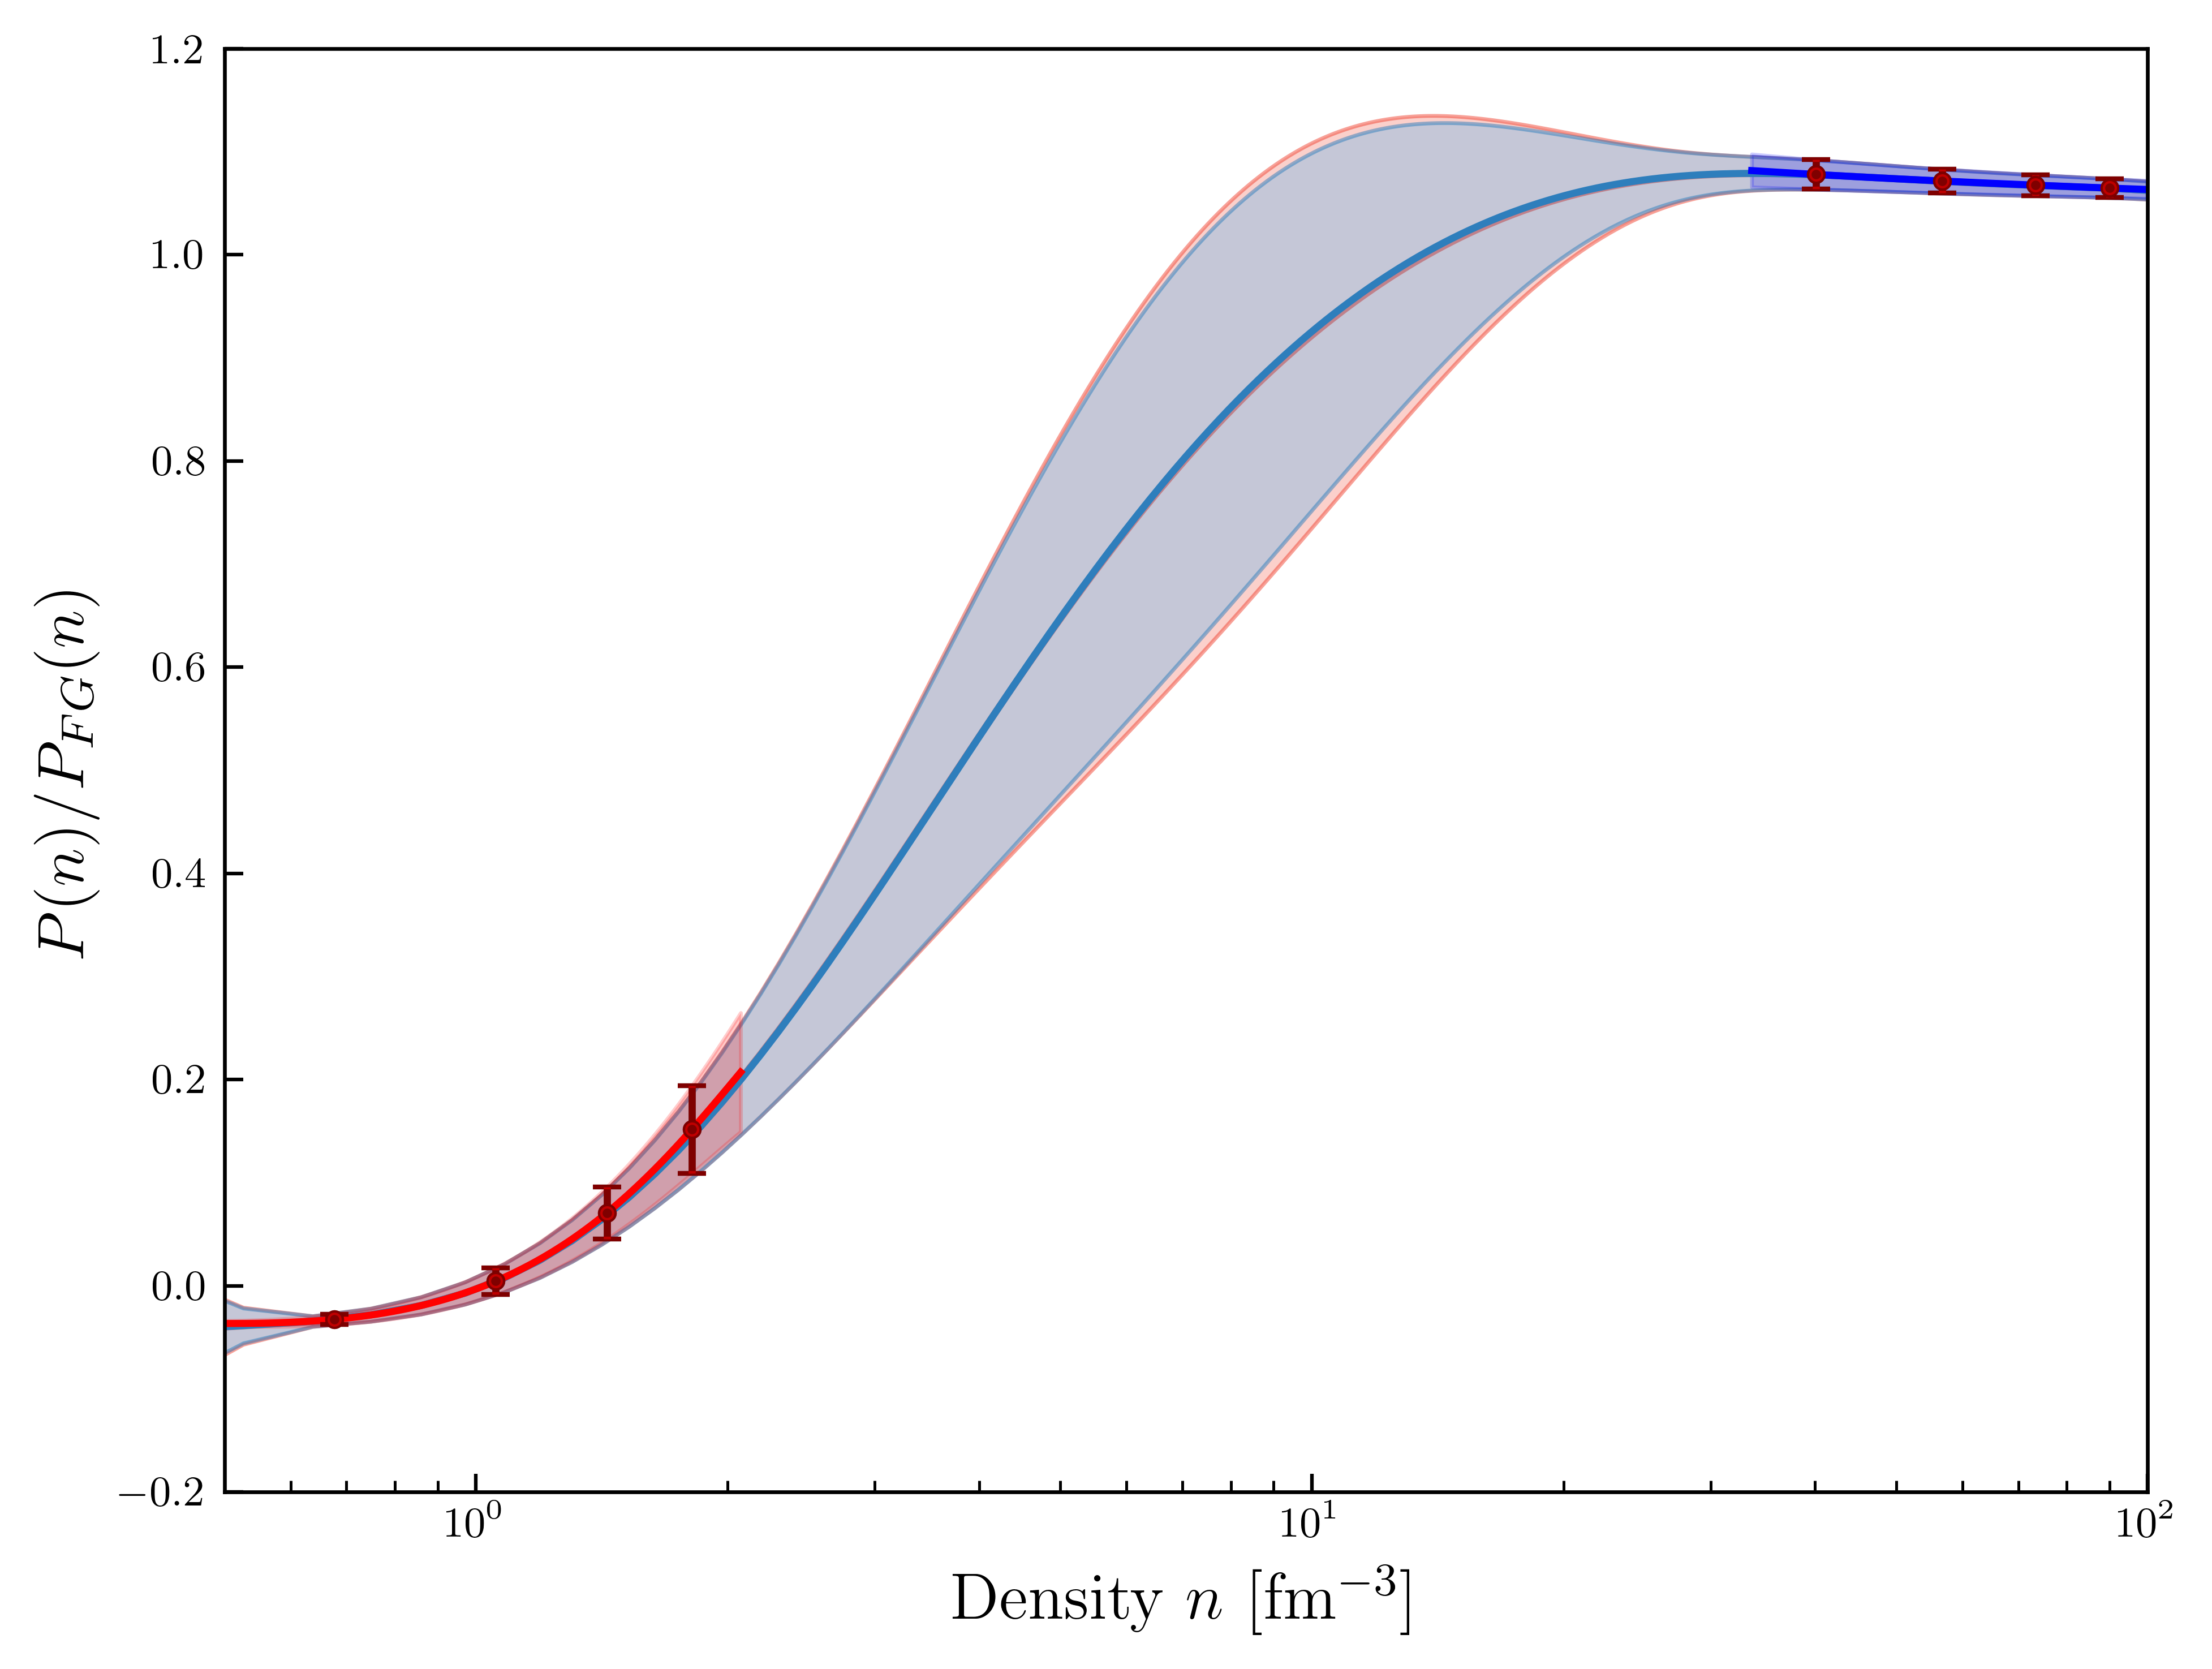

In [17]:
# plot the current data sets
fig, ax = plt.subplots(dpi=600)
ax: Axes
color_xeft = "red"
color_pqcd = "blue"
ax.set_xlim(0.5, 100.0)
ax.set_ylim(-0.2, 1.2)
ax.set_xscale('log')
ax.set_ylabel(r'$P(n)/P_{FG}(n)$', fontsize=14)
ax.set_xlabel(r'Density $n$ [fm$^{-3}$]', fontsize=14)
ax.plot(n_xeft/n0, p_mean_xeft, color='red', label=r'ChEFT (N3LO)')
ax.fill_between(n_xeft/n0, p_mean_xeft-p_stdv_xeft, \
                p_mean_xeft+p_stdv_xeft, alpha=0.2, color=color_xeft)
ax.plot(data_pqcd['density'][200:]/n0, data_pqcd['mean'][200:,-1], color=color_pqcd, label=r'pQCD (N2LO)')
ax.fill_between(data_pqcd['density'][200:]/n0, data_pqcd['mean'][200:,-1]-data_pqcd['std_dev'][200:,-1], \
                data_pqcd['mean'][200:,-1]+data_pqcd['std_dev'][200:,-1], color=color_pqcd, alpha=0.2)
ax.errorbar(x=training_data['dens']/n0, y=training_data['mean'], yerr=training_data['std'], **errorbar_kwargs)
ax.errorbar(x=training_data_2['dens']/n0, y=training_data_2['mean'], yerr=training_data_2['std'], \
            **errorbar_kwargs_2)

# GP results and uncertainty bands
ax.plot(density_test/n0, y_pred, c=colors[0], label=r'Mixed model (GP)', zorder=-1)
ax.fill_between(density_test/n0, y_pred-y_stdv, y_pred+y_stdv, facecolor=light_colors[0], \
                edgecolor=colors[0], alpha=0.5, zorder=-2)

ax.plot(density_test/n0, y_pred_2, c=colors[1], label=r'Mixed model (doubled points chiral) (GP)', zorder=1)
ax.fill_between(density_test/n0, y_pred_2-y_stdv_2, y_pred_2+y_stdv_2, facecolor=light_colors[1], \
                edgecolor=colors[1], alpha=0.5, zorder=0)

plt.show()

In [18]:
# compare the size of the error bars for both theories below at some select point (last point)
band_chiral = p_stdv_xeft[-1]
band_gp = y_stdv[16]           # 2n0
band_gp1 = y_stdv_2[16]

print('Density at chosen point:', density_test[16], 'fm^-3')

# print out the differences
print('Difference between chiral and GP with 4 points: ', ((band_chiral - band_gp)/(band_chiral))*100)
print('Difference between chiral and GP with 4x points: ', ((band_chiral - band_gp1)/(band_chiral))*100)
print('Difference between the two GPs: ', ((band_gp - band_gp1)/(band_gp + band_gp1))*100)

Density at chosen point: 0.3409899888765294 fm^-3
Difference between chiral and GP with 4 points:  5.878319062449493
Difference between chiral and GP with 4x points:  6.5254992650158234
Difference between the two GPs:  0.3449858077047852


In [19]:
# correlation coefficients with pQCD
# check out the covariance matrix
print(y_cov.shape)
print(y_cov_2.shape)
index_2n0 = np.where([density_test[i] >= 0.34 for i in range(len(density_test))])[0][0]
print([index_2n0])
index_40n0 = np.where([density_test[i] >= 6.56 for i in range(len(density_test))])[0][0]

# covariances
y_var0_2n0 = y_cov[index_2n0, index_2n0]
y_var0_40n0 = y_cov[index_40n0, index_40n0]
y_cross0_2n0_40n0 = y_cov[index_2n0, index_40n0]

# covariances between 5n0 and 40n0 here
y_var1_2n0 = y_cov_2[index_2n0, index_2n0]
y_var1_40n0 = y_cov_2[index_40n0, index_40n0]
y_cross1_2n0_40n0 = y_cov_2[index_2n0, index_40n0]

# correlation coefficients
corr_coeff = y_cross0_2n0_40n0 / (np.sqrt(y_var0_2n0) * np.sqrt(y_var0_40n0))
corr_coeff_2 = y_cross1_2n0_40n0 / (np.sqrt(y_var1_2n0) * np.sqrt(y_var1_40n0))
print('Correlation coefficient, blue curve: ', corr_coeff)
print('Correlation coefficient, purple curve: ', corr_coeff_2)

(899, 899)
(899, 899)
[16]
Correlation coefficient, blue curve:  0.006103472695876436
Correlation coefficient, purple curve:  0.007015313922441342


Well, this really burns my ass. We have seen some truncation error shrinking in this testing, but it is not obvious where this is coming from, other than possibly the covariance structure being input into the kernel (I see this, with SNM, whenever the kernel is pretty different for more points).